# Pandas, NumPy

## Short links from agreement between usa.gov data from bit.ly

In [ ]:
%pwd

In [ ]:
import json
import os
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import division

In [ ]:
path = 'data/short_links.txt'

In [ ]:
open(path).readline()

In [ ]:
records = [json.loads(line) for line in open(path)]

In [ ]:
print(f"{records[0]=}\n{records[0]['tz']=}")

### Counting time zones in pure Python

In [ ]:
try:
    time_zones = [rec['tz'] for rec in records]

except KeyError:
    print('There is no "tz"-key')

    time_zones = [rec['tz'] for rec in records if 'tz' in rec]


In [ ]:
time_zones[:10]


In [ ]:
def get_counts(sequence):
    counts = defaultdict(int)  # values will initialize to 0
    for x in sequence:
        counts[x] += 1

    return counts


counts = get_counts(time_zones)
print(f"{counts=}\n{len(time_zones)=}")

In [ ]:
counts['America/New_York']

In [ ]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()

    return value_key_pairs[-n:]

top_counts(counts)

In [ ]:
counts = Counter(time_zones)
counts.most_common(10)

### Counting time zones with pandas

In [ ]:
%matplotlib inline

In [ ]:
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)

In [ ]:
lines = open(path).readlines()
records = [json.loads(line) for line in lines]

In [ ]:
frame = pd.DataFrame(records)
frame

In [ ]:
frame['tz'][:10]

In [ ]:
tz_counts = frame['tz'].value_counts()
tz_counts[:10]

In [ ]:
clean_tz = frame['tz'].fillna('Missing')
clean_tz[clean_tz == ''] = 'Unknown'
tz_counts = clean_tz.value_counts()
tz_counts[:10]

In [ ]:
plt.figure('figure', figsize=(10, 4))
tz_counts[:10].plot(kind='barh', rot=0)

In [ ]:
print(f"{frame['a'][1]=}\n{frame['a'][50]=}\n{frame['a'][51]=}")

In [ ]:
results = pd.Series([x.split()[0] for x in frame.a.dropna()])
results[:5]

In [ ]:
results.value_counts()

In [ ]:
frame.a.dropna()

In [ ]:
cframe = frame[frame.a.notnull()]  # notnull() set value to True if feature is not empty
cframe

In [ ]:
operating_system = np.where(
    cframe['a'].str.contains('Windows'),
    'Windows', 'Not Windows'
)
operating_system[:5]

In [ ]:
# TODO how works groupby in this case?
by_tz_os = cframe.groupby(['tz', operating_system])

In [ ]:
# NB pandas.core.series.Series -> unstack() -> pandas.core.frame.DataFrame
agg_counts = by_tz_os.size().unstack().fillna(0)
agg_counts[:10]

In [ ]:
# Use to sort in ascending order
indexer = agg_counts.sum(1).argsort()
indexer[:10]

In [ ]:
count_subset = agg_counts.take(indexer)[-10:]
count_subset

In [ ]:
count_subset.plot(kind='barh', stacked=True);

In [ ]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)
normed_subset.plot(kind='barh', stacked=True)

## MovieLens 1M data set

In [ ]:
encoding = 'latin1'

upath = os.path.expanduser('data/movielens/users.dat')
rpath = os.path.expanduser('data/movielens/ratings.dat')
mpath = os.path.expanduser('data/movielens/movies.dat')

unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
mnames = ['movie_id', 'title', 'genres']

users = pd.read_csv(upath, sep='::', header=None, names=unames, encoding=encoding)
ratings = pd.read_csv(rpath, sep='::', header=None, names=rnames, encoding=encoding)
movies = pd.read_csv(mpath, sep='::', header=None, names=mnames, encoding=encoding)

In [ ]:
users[:5]

In [ ]:
ratings[:5]

In [ ]:
movies[:5]

In [ ]:
ratings

In [ ]:
data = pd.merge(pd.merge(ratings, users), movies)
data

In [ ]:
mean_ratings = data.pivot_table(
    'rating', index='title',
    columns='gender', aggfunc='mean'
)
mean_ratings[:5]

In [ ]:
ratings_by_title = data.groupby('title').size()
ratings_by_title[:5]

In [ ]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]
active_titles[:10]

In [ ]:


mean_ratings = mean_ratings.loc[active_titles]
mean_ratings

In [ ]:
mean_ratings = mean_ratings.rename(
    index={
        'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)':
        'Seven Samurai (Shichinin no samurai) (1954)'
    }
)

In [ ]:
top_female_ratings = mean_ratings.sort_values('F', ascending=False)
top_female_ratings[:10]

### Measuring rating disagreement

In [ ]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']
sorted_by_diff = mean_ratings.sort_values('diff')
sorted_by_diff[:15]

In [ ]:
# Reverse order of rows, take first 15 rows
sorted_by_diff[::-1][:15]

In [ ]:
# Standard deviation of rating grouped by title
rating_std_by_title = data.groupby('title')['rating'].std()
# Filter down to active_titles
rating_std_by_title = rating_std_by_title.loc[active_titles]
# Order Series by value in descending order
rating_std_by_title.sort_values(ascending=False)[:10]

### US Baby Names

In [ ]:
np.set_printoptions(precision=4)
%pwd

In [ ]:
!head -n 10 data/baby_names/yob1880.txt

In [ ]:
path = 'data/baby_names'
filenames = os.listdir(path)
columns = ['name', 'sex', 'births']
pieces = []

for filename in filenames:
    frame = pd.read_csv(f"{path}/{filename}", names=columns)
    frame['year'] = f''.join(x for x in filename if x.isdigit())
    pieces.append(frame)

# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

In [ ]:
total_births = names.pivot_table(
    'births', index='year',
    columns='sex', aggfunc=sum
)

In [ ]:
total_births.tail()

In [ ]:
total_births.plot(title='Total births by sex and year')

In [ ]:
def add_prop(group):
    # Integer division floors
    births = group.births.astype(float)

    group['prop'] = births / births.sum()
    return group

# Доля младенцев, получивших данное имя, относительно общего числа родившихся.
names = names.groupby(['year', 'sex']).apply(add_prop)
names

In [ ]:
# Сумма по группам достаточно близка к 1
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)


In [ ]:
pieces = []
for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])

top1000 = pd.concat(pieces, ignore_index=True)

In [ ]:
top1000.index = np.arange(len(top1000))

In [ ]:
top1000

#### Boy names that became girl names (and vice versa)

In [225]:
all_names = top1000.name.unique()
mask = np.array(['lesl' in x.lower() for x in all_names])
lesley_like = all_names[mask]
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

In [226]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee       993
Lesley     35033
Lesli        929
Leslie    378168
Lesly      11433
Name: births, dtype: int64

In [227]:
table = filtered.pivot_table('births', index='year',
                             columns='sex', aggfunc='sum')
table = table.div(table.sum(1), axis=0)
table.tail()

sex,F,M
year,,
2014,1.0,NaN
2015,1.0,NaN
2016,1.0,NaN
2017,1.0,NaN
2018,1.0,NaN


In [229]:
plt.close('all')

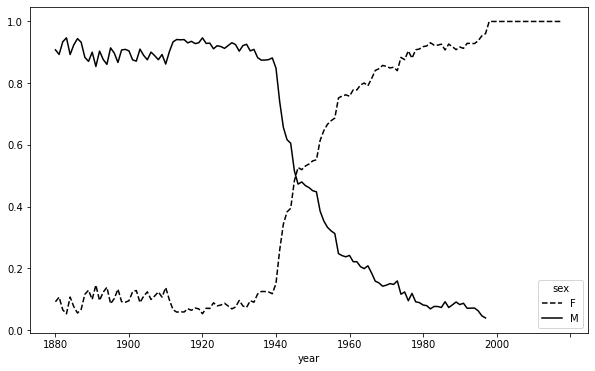

In [230]:
table.plot(style={'M': 'k-', 'F': 'k--'})